In [3]:
# imports
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

import gensim
from gensim.test.utils import datapath
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [ ]:
!pip install stopwords_guilannlp
!pip install transformers
!pip install datasets

In [ ]:
!unzip ./data.zip

In [4]:
def read_dataset(path='./data/', print_shapes = True):
    # Load data
    train = pd.read_csv(path + 'train_set.csv')
    test = pd.read_csv(path + 'test_set.csv')

    if print_shapes:
        print()
        print("Train dataset shape is : {}".format(train.shape))
        print("Test dataset shape is : {}".format(test.shape))

    return train, test

In [57]:
train_data, test_data = read_dataset(print_shapes=True)


Train dataset shape is : (37899, 3)
Test dataset shape is : (10000, 2)


In [6]:
train_data.head()

,app_id,description_fa,label
0,0,<p>بازی مین روب یک برنامه فکری است که باید مین...,1
1,1,<p>دراین بازی تعدادی عکس برای شما نشان داده می...,1
2,2,<br>تلاش نافرجام برای درک «بوفالو»<br>مرگ پایا...,7
3,3,<p>فیلم نما ، برنامه ای برای دانلود و پخش آنلا...,7
4,4,<p>* این برنامه حاوی بیش از 500 عکس و ژست برای...,7


In [7]:
test_data.head()

,app_id,description_fa
0,40000,<h4>در این برنامه یکی از بازی های جالب میکرو ر...
1,40001,<p>بازی آموزشی میلونر زبان انگلیسی برای تقویت ...
2,40002,<p> <b>موضوع رو می بینی و کلمات رو پیدا می کنی...
3,40003,<p>نرم افزار فول تلگرام در کنار تلگرام امكانات...
4,40004,<p> فکر می کنی خیلی سریع هستی نه؟ <br> ...


In [58]:
def clean_text(dataframe,text_field):

    df = dataframe.copy()
    # Lower case english letters
    df[text_field] = df[text_field].str.lower()
    # clean html tags of <br><br/> and also \/ signs
    #df[text_field] = df[text_field].str.replace(r"(<br\s*/><br\s*/>)|(\-)|(\/)", " ")

    cleanr = re.compile('<.*?>')
    df[text_field] = df[text_field].str.replace(cleanr, " ")
    df[text_field] = df[text_field].str.replace(r"\n"," ")
    # clean http word
    df[text_field] = df[text_field].str.replace(r"http\S+"," ")
    # clean numbers and english letters
    df[text_field] = df[text_field].str.replace(r"[0-9]", " ")
    df[text_field] = df[text_field].str.replace(r"[۰۱۲۳۴۵۶۷۸۹]", " ")
    df[text_field] = df[text_field].str.replace(r"[a-z]", " ")
    # remove emojis and other wierd stuff
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        #u"\u200c"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    df[text_field] = df[text_field].str.replace(wierd_pattern, " ")

    df[text_field] = df[text_field].str.replace(r"[\.+ \…]", " ")
    # remove all of punctuation    
    df[text_field] = df[text_field].str.replace("[«»–=.;،:!\'?؟,\"_()&\[\]@]"," ")
    df[text_field] = df[text_field].str.replace("؛"," ")
    # finally remove two spaces or more
    df[text_field] = df[text_field].str.replace(r"\s+", " ")

    return df

# preprocess and clean text
df_train = clean_text(train_data,"description_fa")
df_test = clean_text(test_data,"description_fa")


y_train = df_train['label'].copy()

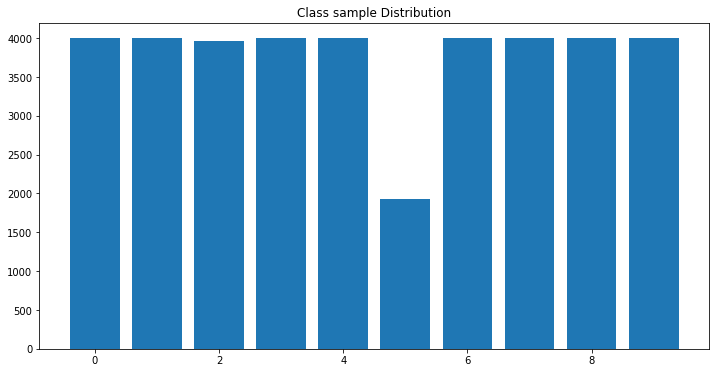

In [9]:
plt.figure(figsize=(12,6))
plt.bar(*np.unique(y_train,return_counts=True))
plt.title("Class sample Distribution")
plt.show()

In [59]:
!pip install parsivar
from parsivar import Normalizer
from parsivar import Tokenizer
from parsivar import FindStems
from stopwords_guilannlp import stopwords_output


tokenizer = Tokenizer()
normalizer = Normalizer()
stopwords = stopwords_output("Persian", "nar")

In [ ]:
def create_string(listin):
    st=""
    for i in range(len(listin)):
        st=st+listin[i]+" "
    return st

def tokenize_remove_stopwords(x):
  y = tokenizer.tokenize_words(normalizer.normalize(x))
  return [word for word in y if not word in stopwords]

def preprocess(dataframe):
    df = dataframe.copy()
    df['description_fa'] = df['description_fa'].apply(tokenize_remove_stopwords)
    df['description_fa'] = df['description_fa'].apply(create_string)
    return df

df_train = preprocess(df_train)
df_test = preprocess(df_test)

In [15]:
df_train.head()

,app_id,description_fa,label
0,0,بازی مین برنامه فکری مین‌های موجود صفحه بازی ک...,1
1,1,دراین بازی عکس خاطر سپرده جواب پرسش‌های متداول...,1
2,2,تلاش نافرجام درک بوفالو مرگ پایان ماجرا آنجاست...,7
3,3,فیلم نما برنامه‌ای دانلود پخش آنلاین فیلم سریا...,7
4,4,برنامه حاوی عکس ژست مدل عکاسی شدنه کتاب مدل‌ها...,7


In [ ]:
classes = sorted(map(int, df_train['label'].unique()))
print(classes)

In [63]:
from transformers import AutoTokenizer , BertConfig

config = BertConfig.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased", **{
        'label2id': classes,
        'id2label': classes,
    })

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [64]:
def tokenize(x):
    y = tokenizer(x, padding="max_length", max_length=150, truncation=True)
    return y

def input_ids(x):
    return np.asarray(x['input_ids'])
def attention_mask(x):
    return np.asarray(x['attention_mask'])
def token_type_ids(x):
    return np.asarray(x['token_type_ids'])
  
def preprocess(dataframe):
    df = dataframe.copy()
    df['inputs'] = df['description_fa'].apply(tokenize)
    df['input_ids'] = df['inputs'].apply(input_ids)
    df['attention_mask'] =  df['inputs'].apply(attention_mask)
    # below is not needed for distilbert!
    df['token_type_ids'] =  df['inputs'].apply(token_type_ids)

    return df

In [65]:
# Word level tokenization and stop words removal
df_train_final = preprocess(df_train)
df_test_final = preprocess(df_test)

In [34]:
df_train_final.head()

,app_id,description_fa,label,inputs,input_ids,attention_mask,token_type_ids
0,0,بازی مین برنامه فکری مین‌های موجود صفحه بازی ک...,1,"[input_ids, token_type_ids, attention_mask]","[2, 3057, 3800, 3329, 7182, 50574, 3731, 4863,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,دراین بازی عکس خاطر سپرده جواب پرسش‌های متداول...,1,"[input_ids, token_type_ids, attention_mask]","[2, 9111, 3057, 4655, 3804, 5340, 6173, 17092,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,تلاش نافرجام درک بوفالو مرگ پایان ماجرا آنجاست...,7,"[input_ids, token_type_ids, attention_mask]","[2, 3743, 23329, 5520, 36172, 4128, 3559, 6518...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,فیلم نما برنامه‌ای دانلود پخش آنلاین فیلم سریا...,7,"[input_ids, token_type_ids, attention_mask]","[2, 3169, 13248, 8503, 7510, 4751, 5442, 3169,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,برنامه حاوی عکس ژست مدل عکاسی شدنه کتاب مدل‌ها...,7,"[input_ids, token_type_ids, attention_mask]","[2, 3329, 6037, 4655, 26193, 3945, 7897, 3322,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [66]:
df_train_final, df_valid = train_test_split(df_train_final, test_size=0.05, stratify=df_train_final['label'])

In [67]:
train_features = {x: tf.convert_to_tensor(list(df_train_final[x])) for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, df_train_final['label']))
train_tf_dataset = train_tf_dataset.shuffle(len(train_tf_dataset)).batch(8)

valid_features = {x: tf.convert_to_tensor(list(df_valid[x])) for x in tokenizer.model_input_names}
valid_tf_dataset = tf.data.Dataset.from_tensor_slices((valid_features, df_valid['label']))
valid_tf_dataset = valid_tf_dataset.shuffle(len(valid_tf_dataset)).batch(8)

In [68]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased", config=config)

Some layers from the model checkpoint at HooshvareLab/distilbert-fa-zwnj-base were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/distilbert-fa-zwnj-base and are newly initialized: ['dropout_115', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream 

In [78]:
#checkPointer = tf.keras.callbacks.ModelCheckpoint('./best_model.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.fit(train_tf_dataset, validation_data=valid_tf_dataset, epochs=2)

Epoch 1/2
4501/4501 [==============================] - 443s 97ms/step - loss: 1.0457 - sparse_categorical_accuracy: 0.6316 - val_loss: 0.8397 - val_sparse_categorical_accuracy: 0.7103
Epoch 2/2
4501/4501 [==============================] - 432s 96ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.7748 - val_loss: 0.8315 - val_sparse_categorical_accuracy: 0.7282


In [79]:
test_features = {x: tf.convert_to_tensor(list(df_test_final[x])) for x in tokenizer.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices(test_features)
test_tf_dataset = test_tf_dataset.batch(8)

In [80]:
predictions = model.predict(test_tf_dataset)
output = df_test.copy()
output['label'] = np.argmax(predictions[0], axis=1)
result = pd.DataFrame(output, columns=['app_id','label'])
result.to_csv('./prediction.csv', index=False)

In [ ]:
model.save_pretrained("./model_clf_bert")

In [ ]:
!zip -r model.zip './model_clf_bert/'